In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Transformation utilties
-------------------------

In [2]:
units = {'x':'mm','y':'mm','r':'mm','z':'mm','px':'keV/c','py':'keV/c','pz':'MeV/c','t':'ps','q':'pC','thetax':'mrad','thetay':'mrad'}
from distgen import Generator
from distgen.plot import plot_dist2d, plot_radial_dist
from distgen.physical_constants import unit_registry as unit
from matplotlib import pyplot as plt
import yaml
import numpy as np
from pprint import pprint

A set of transformations can be applied to a beam when it is created by adding a dictionary called 'transforms' at the top level of the Distgen input structure (in either dictionary or YAML format).


Transformations are added to this dictionary with a unique identifier key.  The key `'order'` is protected and should not be used. Each transformation definition must be a dictionary containing a `'type'` key associated with a known transform function and the variable(s) it acts on.  A simple example is given by a translation in x: the type key is then "type: translate x".  All input parameters for the transformation should be input at the same level as the 'type' key. Physical quantities with units should be dictionaries with a 'value' and 'units' key/value pair supplied. 

Unless specified, transformations are applied in the order they are input in the transforms dictionary. Because transformation operations often do not commute, the user may specify a desired order by adding a list of transformation ID's to the tranform dictionary using the key `'order'`. Because python and yaml do not universally guarantee order is preserved, it is recommended to always specify the order list when the number of transforms is more than one.

In the example below, two transforms are include: scaling a round beam so that it is oval, and then rotated the beam by 45 deg.  In this example the full input to Distgen is printed, in subsequent examples, only the transform details are printed.

/Users/colwyngulliford/GitHub/distgen/distgen/generator.py:231: UserWarning: Input variable n_particle was a float, expected int.
  warnings.warn('Input variable n_particle was a float, expected int.')


Input:
 order:
- t1
- t2
- t3
t1:
  sigma_x:
    units: millimeter
    value: 3.0
  type: set_std x
t2:
  angle:
    units: degree
    value: 45.0
  type: rotate2d x:y
t3:
  delta:
    units: millimeter
    value: 1.0
  type: translate y



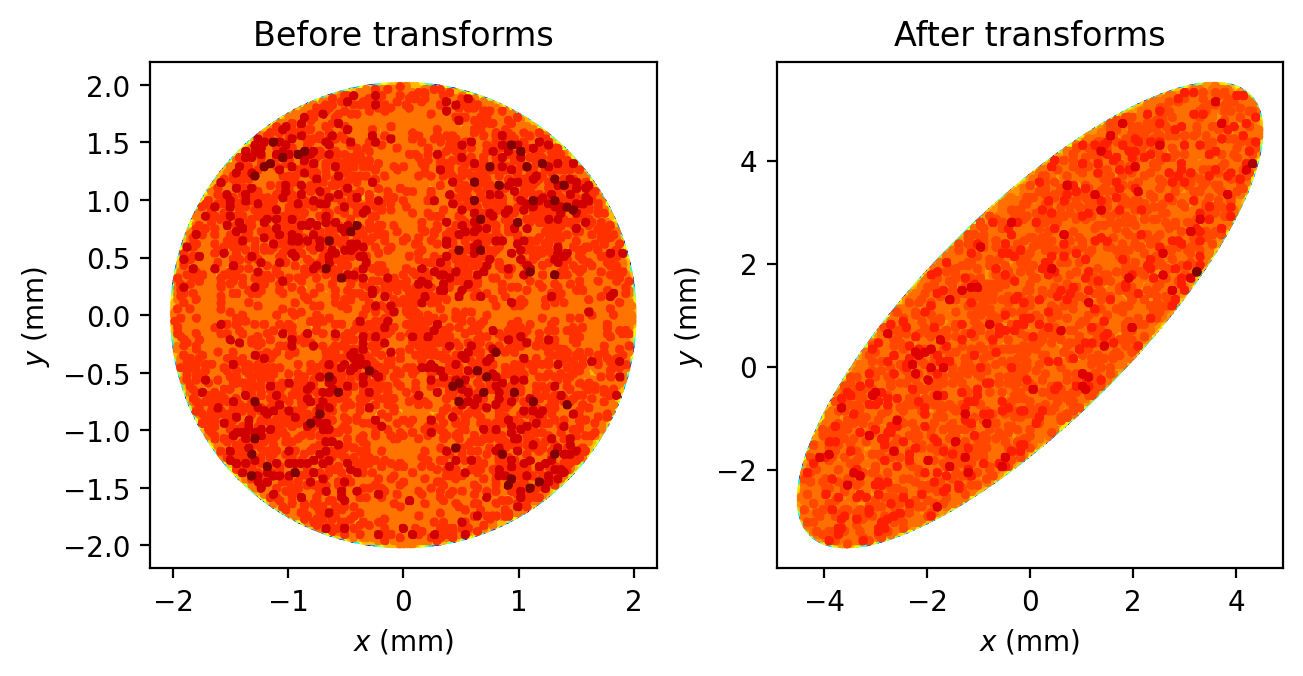

In [3]:
gen = Generator('data/beer.can.in.yaml', verbose=0) 

initial_beam = gen.beam()

setstdx = {'type':'set_std x', 'sigma_x':{'value': 3, 'units': 'mm'}}
rot2dxy = {'type':'rotate2d x:y', 'angle':{'value':45, 'units':'deg'}}
transy = {'type': 'translate y', 'delta': {'value': 1, 'units': 'mm'}}

gen['transforms']={'t1':setstdx, 't2':rot2dxy, 't3':transy, 'order':['t1', 't2', 't3']}

final_beam = gen.beam()

print('Input:\n', yaml.dump(gen.input['transforms']))

fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True)

plot_dist2d(initial_beam, 'x', units['x'], 'y', units['y'], axis='equal', ax=ax[0]);
ax[0].set_title('Before transforms');

plot_dist2d(final_beam, 'x', units['x'], 'y', units['y'], axis='equal', ax=ax[1]);
ax[1].set_title('After transforms');

Distgen provides a set of basic transformation utilities that can be applied the particle coordinates of a beam object.  Here the basic examples are discused: the transformation functions are defined as well as how to use them from the standard Distgen input structure.  Note the these transformation operations do not in general commute.

The primary example used is that of a uniform radial distribution.

# Translations

Translations of the coordinate $u$ are defined by: $u\rightarrow u + \Delta u$.

Input:
 order:
- tx
- ty
tx:
  delta:
    units: millimeter
    value: 3.0
  type: translate x
ty:
  delta:
    units: millimeter
    value: -1
  type: translate y



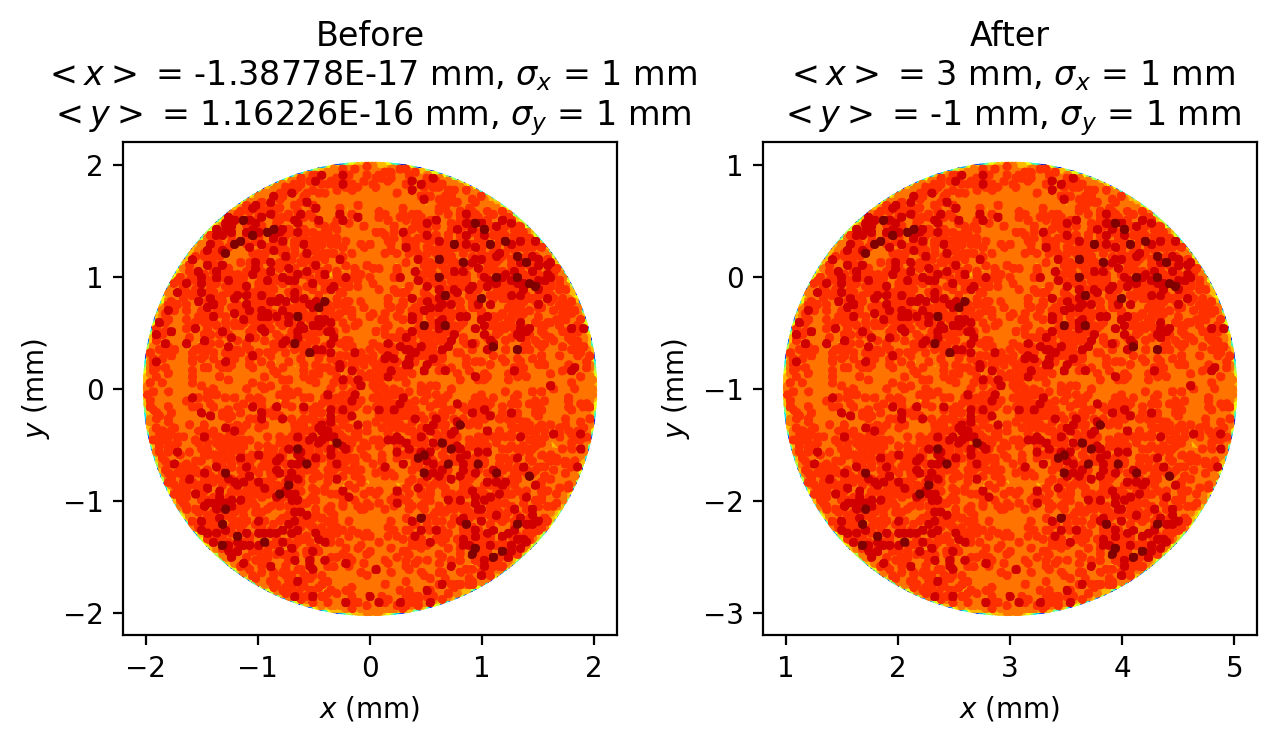

In [4]:
# Translations: a translation of a single coordinate are handled by transforms.translate
from distgen.transforms import translate

gen=Generator('data/beer.can.in.yaml',verbose=0)
beam1=gen.beam()

transx = {'type':'translate x', 'delta':{'value':+3, 'units':'mm'}}
transy = {'type':'translate y', 'delta': '-1 mm'}

gen['transforms']={'tx':transx, 'ty':transy, 'order':['tx','ty']}
beam2 = gen.beam()

print('Input:\n',yaml.dump(gen.input['transforms']))

fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True)

plot_dist2d(beam1, 'x', units['x'], 'y', units['y'], axis='equal', ax=ax[0], title_on=True);
ax[0].set_title(f'Before\n{ax[0].get_title()}')

plot_dist2d(beam2, 'x', units['x'], 'y', units['y'], axis='equal', ax=ax[1], title_on=True);
ax[1].set_title(f'After\n{ax[1].get_title()}');

Input:
 order:
- tx
- ty
tx:
  avg_x:
    units: millimeter
    value: 3.0
  type: set_avg x
ty:
  avg_y:
    units: millimeter
    value: -1.0
  type: set_avg y



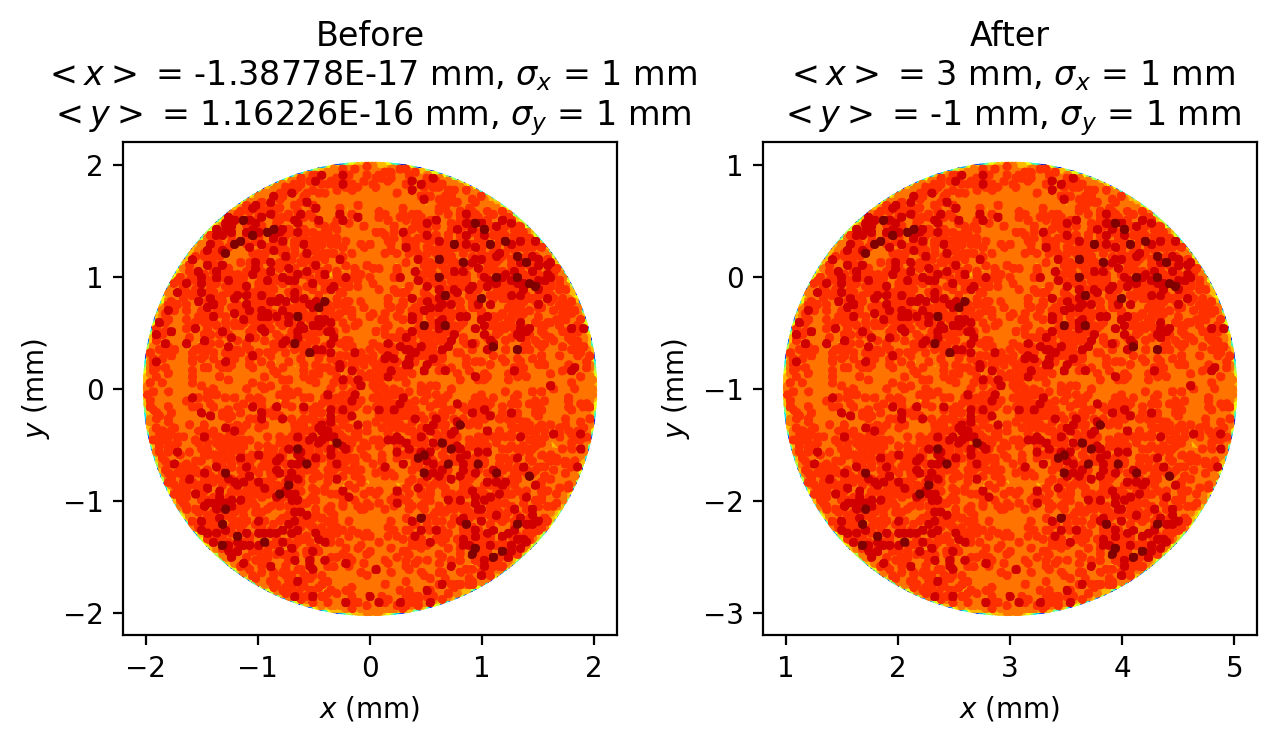

In [5]:
gen=Generator('data/beer.can.in.yaml',verbose=0)
beam1=gen.beam()

setavgx = {'type':'set_avg x', 'avg_x':{'value':+3, 'units':'mm'}}
setavgy = {'type':'set_avg y', 'avg_y':{'value':-1, 'units':'mm'}}

gen['transforms']={'tx':setavgx, 'ty':setavgy, 'order':['tx', 'ty']}
beam2 = gen.beam()

print('Input:\n',yaml.dump(gen.input['transforms']))

fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True)

plot_dist2d(beam1, 'x', units['x'], 'y', units['y'], axis='equal', ax=ax[0], title_on=True);
ax[0].set_title(f'Before\n{ax[0].get_title()}')

plot_dist2d(beam2, 'x', units['x'], 'y', units["y"], axis='equal', ax=ax[1], title_on=True);
ax[1].set_title(f'After\n{ax[1].get_title()}');

# Scaling

Basic scaling is handled using transforms.scale.  To scale the $x$ coordinate of the beam by $\alpha$ use:

scale(beam,'x',$\alpha$) 

where $\alpha$ is a dimensionless quantity or float.  Note that if the $<x>\neq0$ then 
$<x>\rightarrow\alpha<x>$.  It is possible to fix the average value under scaling using:

scale(beam, 'x', $\alpha$, fix_average='True') 


Input:
 order:
- t
- s
s:
  fix_average: true
  scale: 2
  type: scale x
t:
  delta:
    units: millimeter
    value: 3.0
  type: translate x



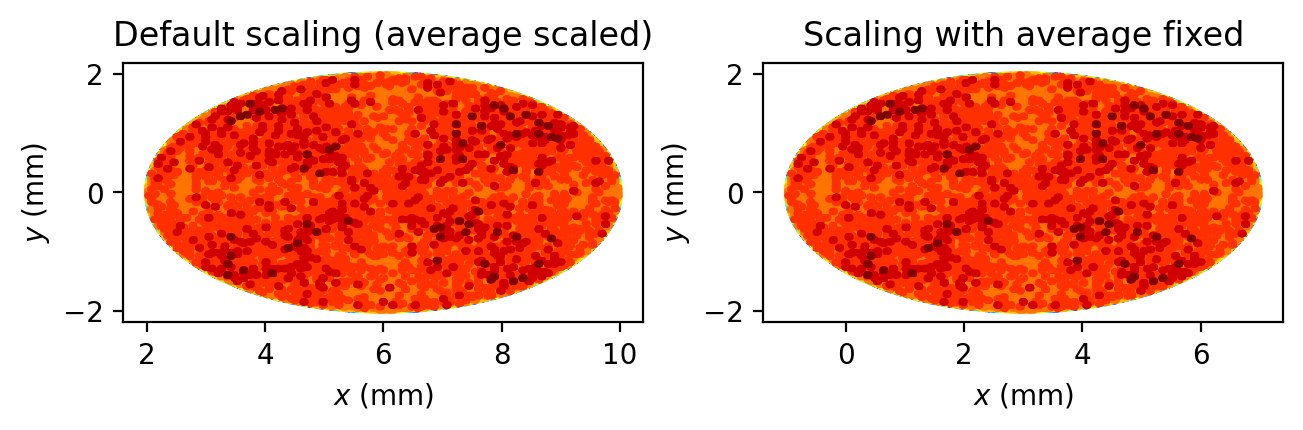

In [6]:
from distgen.transforms import scale

gen=Generator('data/beer.can.in.yaml',verbose=0)
beam1 = gen.beam()

transx = {'type':'translate x', 'delta':{'value': 3,'units': 'mm'}}
scalex = {'type':'scale x', 'scale':2,}

gen['transforms']={'t1':transx, 't2':scalex, 'order':['t1','t2']}
beam1 = gen.beam()

scalex['fix_average']=True

gen['transforms']={'t':transx, 's':scalex, 'order':['t','s']}
beam2 = gen.beam()

print('Input:\n',yaml.dump(gen.input['transforms']))

fig, ax = plt.subplots(1, 2, constrained_layout=True)

plot_dist2d(beam1, 'x', units['x'], 'y', units["y"], axis='equal', ax=ax[0]);
ax[0].set_title('Default scaling (average scaled)');

plot_dist2d(beam2, 'x', units['x'], 'y', units['y'], axis='equal', ax=ax[1]);
ax[1].set_title('Scaling with average fixed');

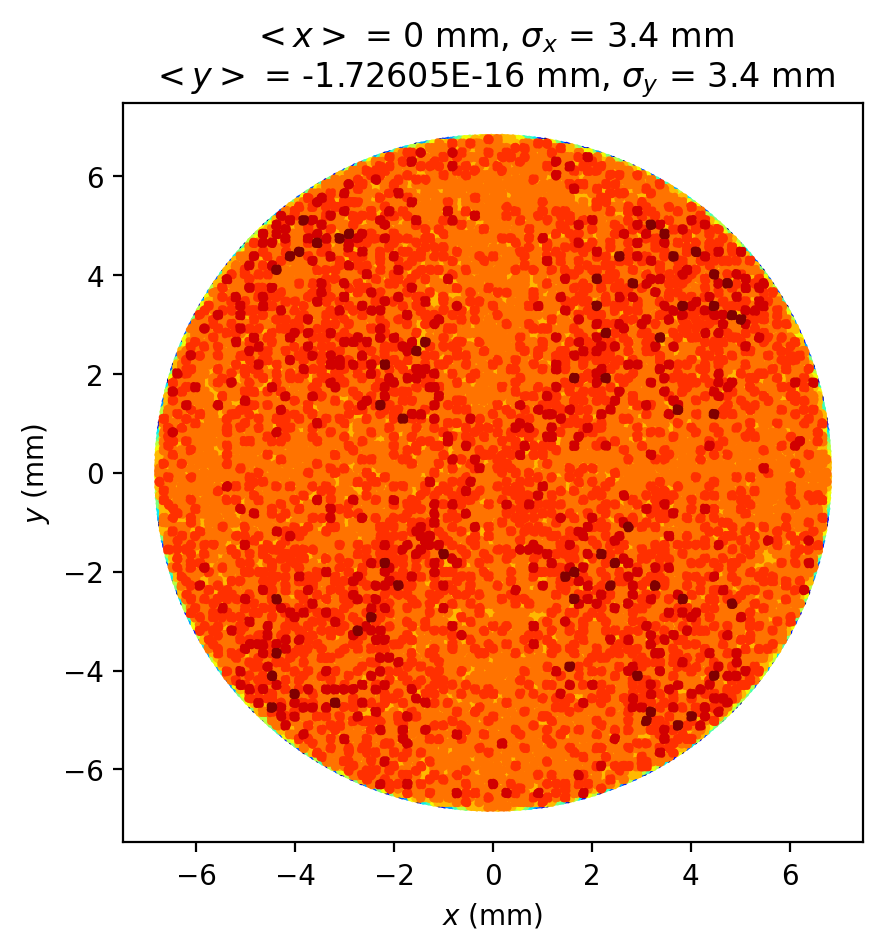

In [7]:
from distgen.transforms import set_stdxy

gen=Generator('data/beer.can.in.yaml',verbose=0)
beam1 = gen.beam()

scalex = {'type':'set_stdxy x:y', 'sigma_xy':{'value':3.4, 'units': 'mm'},}

gen['transforms']={'t1':scalex}
beam2 = gen.beam()

plot_dist2d(beam2, 'x', units['x'], 'y', units["y"], axis='equal', title_on=True);


# Shift and Scale a single coordinate

It is possible to combine a translation with a scaling operation to shift and rescale a coordinate
to have a new standard deviation while keeping the form of the underlying coordinate distribution unchanged. This is accomplished using transforms.set_avg_and_std(...)

Input:
 sx:
  avg_x:
    units: millimeter
    value: -3.0
  sigma_x:
    units: millimeter
    value: 5.0
  type: set_avg_and_std x



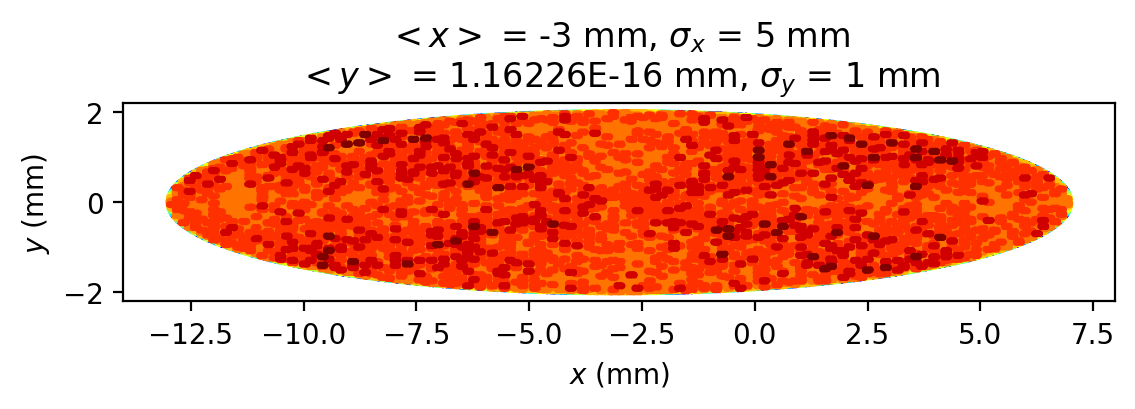

In [8]:
from distgen.transforms import set_avg_and_std

gen=Generator('data/beer.can.in.yaml',verbose=0)

setx = {
    'type':'set_avg_and_std x',
    'avg_x':  {'value': -3, 'units': 'mm'},
    'sigma_x':{'value':  5, 'units': 'mm'}
}

gen['transforms']={'sx':setx}
beam = gen.beam()

print('Input:\n',yaml.dump(gen.input['transforms']))

plot_dist2d(beam, 'x', units['x'], 'y', units['y'], axis='equal', title_on=True);

# Rotating coordinates

Rotation between two coordinates is accomplished using transforms.rotate2d.  In addition to the beam 
object, the user must specify the variables to rotate.  This can be done in a string of the form 'var1:var2' or as a list of strs ['var1','var2'].  The variables supplied must have the same type of units.  The user must also specify an angle in radians or degrees to rotate by. 

Note, the default behavior is to rotate around the coordinate origins (not the coordinate averages) as seen in the plot on the left below. The rotation can be performed about a different origin by setting the keyword arguement 'origin'.  Often it is desirable to set the origin of rotation to be the coordinate centroids. This is done by setting origin='centroid' (as seen in the plot on the right below).

YAML input:
 order:
- sx
- shx
- rxy
rxy:
  angle:
    units: degree
    value: 45.0
  origin: centroid
  type: rotate2d x:y
shx:
  delta:
    units: millimeter
    value: 5.0
  type: translate x
sx:
  scale: 3
  type: scale x



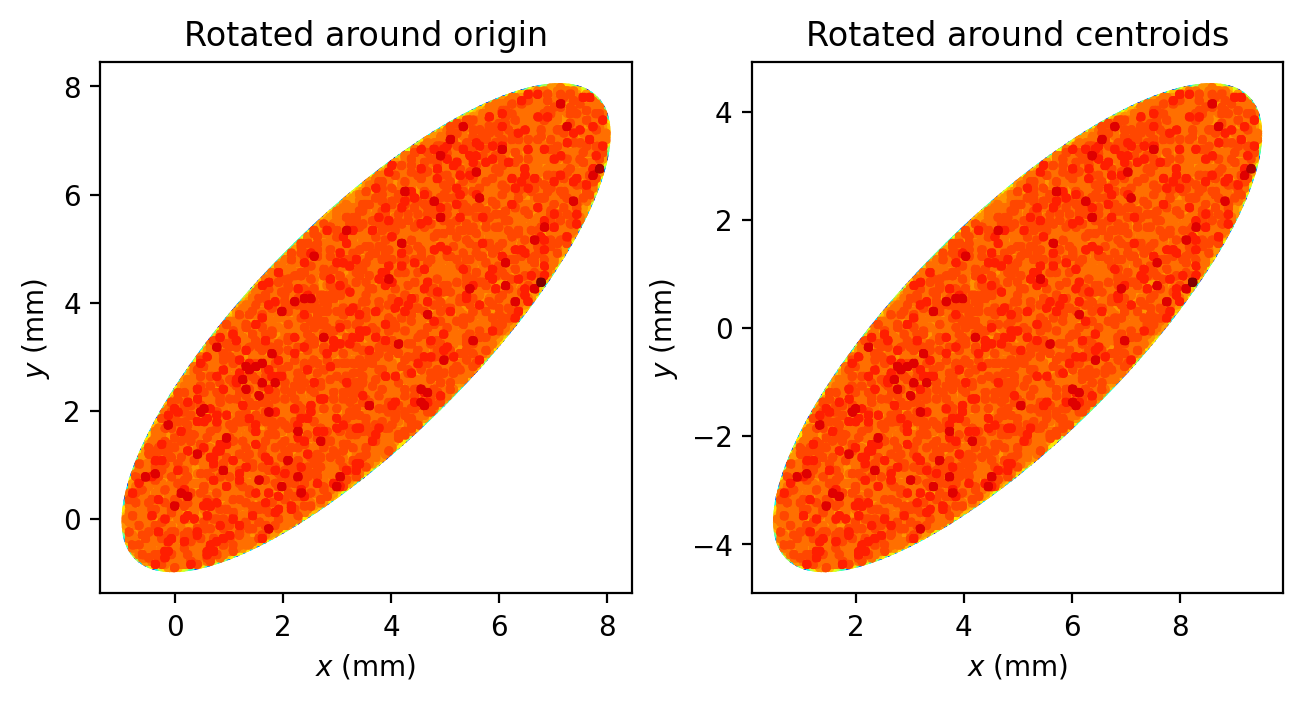

In [9]:
from distgen.transforms import rotate2d

gen=Generator('data/beer.can.in.yaml',verbose=0)

scalex = {'type':'scale x', 'scale':3}
shiftx = {'type': 'translate x', 'delta': {'value': 5, 'units': 'mm'}}
rotxy = {'type':'rotate2d x:y', 'angle':{'value':45, 'units':'deg'}}
            
gen['transforms']={'sx':scalex, 'shx':shiftx, 'rxy':rotxy, 'order':['sx','shx','rxy']}
obeam = gen.beam()

# do with rotation around centroid
gen['transforms:rxy']={'type':'rotate2d x:y', 'angle':{'value':45, 'units':'deg'}, 'origin':'centroid'}

cbeam = gen.beam()
print('YAML input:\n', yaml.dump(gen.input['transforms']))

fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True)
plot_dist2d(obeam, 'x', units['x'], 'y', units['y'], ax=ax[0], axis="equal");
ax[0].set_title('Rotated around origin');

plot_dist2d(cbeam, 'x', units['x'], 'y', units['y'], ax=ax[1], axis="equal");
ax[1].set_title('Rotated around centroids');

# Shear

The shear operation allows one to apply a sheer in a 2D subspace according of the form:

$v\rightarrow v + \alpha u$

This can be useful in a variety of cases such as drifting particles.

YAML:
 s:
  shear_coefficient:
    units: dimensionless
    value: 0.5
  type: shear x:y



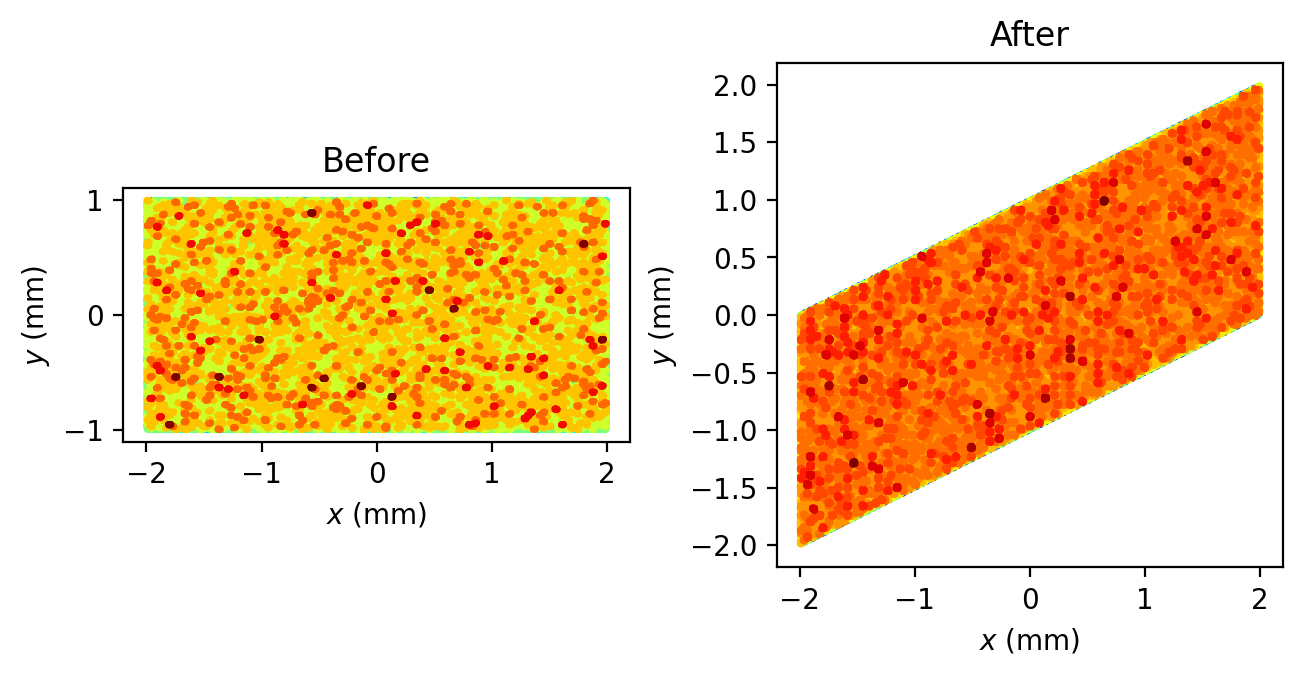

In [10]:
from distgen.transforms import shear

gen=Generator('data/x.y.uniform.in.yaml',verbose=0)
beam1=gen.beam()

gen['transforms']= {'s':{'type':'shear x:y', 'shear_coefficient':{'value': 0.5, 'units': ''}} }
beam2=gen.beam()
print('YAML:\n',yaml.dump(gen.input['transforms']))

fig, ax = plt.subplots(1, 2, constrained_layout=True)
plot_dist2d(beam1, 'x', units['x'], 'y', units['y'], axis="equal",ax=ax[0]);
ax[0].set_title('Before')

plot_dist2d(beam2, 'x', units['x'], 'y', units['y'], axis="equal", ax=ax[1]);
ax[1].set_title('After');

Magnetizing a cylindrical beam provides a more physically relevant application of the sheer function.  Here the magnetization 
$\mathcal{L}$
is added to the particle momentum in the form
$p_x\rightarrow p_x + \frac{\mathcal{L}}{\sigma_{x,y}^2}y$
and $p_y\rightarrow p_y - \frac{\mathcal{L}}{\sigma_{x,y}^2}x$.  This results in a transverse emittance of
$\sqrt{\epsilon_{n,x,uncor}^2 + \mathcal{L}^2}$.  Note that using the definitions of cylindrical variables it is possible to show this is equivalent to a sheer of 
$p_{\theta}\rightarrow p_{\theta}-\frac{\mathcal{L}}{\sigma_{x,y}^2}r$. 

For symplicity, a magnetization function has been defined to perform the above transform given the magnetization $\mathcal{L}$.  Currently this assumes a cylindrically symmetric bunch.

eV·µm/c
YAML:
 m:
  magnetization:
    units: electron_volt * micrometer / speed_of_light
    value: -25549947.499999996
  type: magnetize r:ptheta

Initial emittance: 0.541796 µm
Final emittance: 50.0029 µm
Error: -5.4643748059746144e-05 %


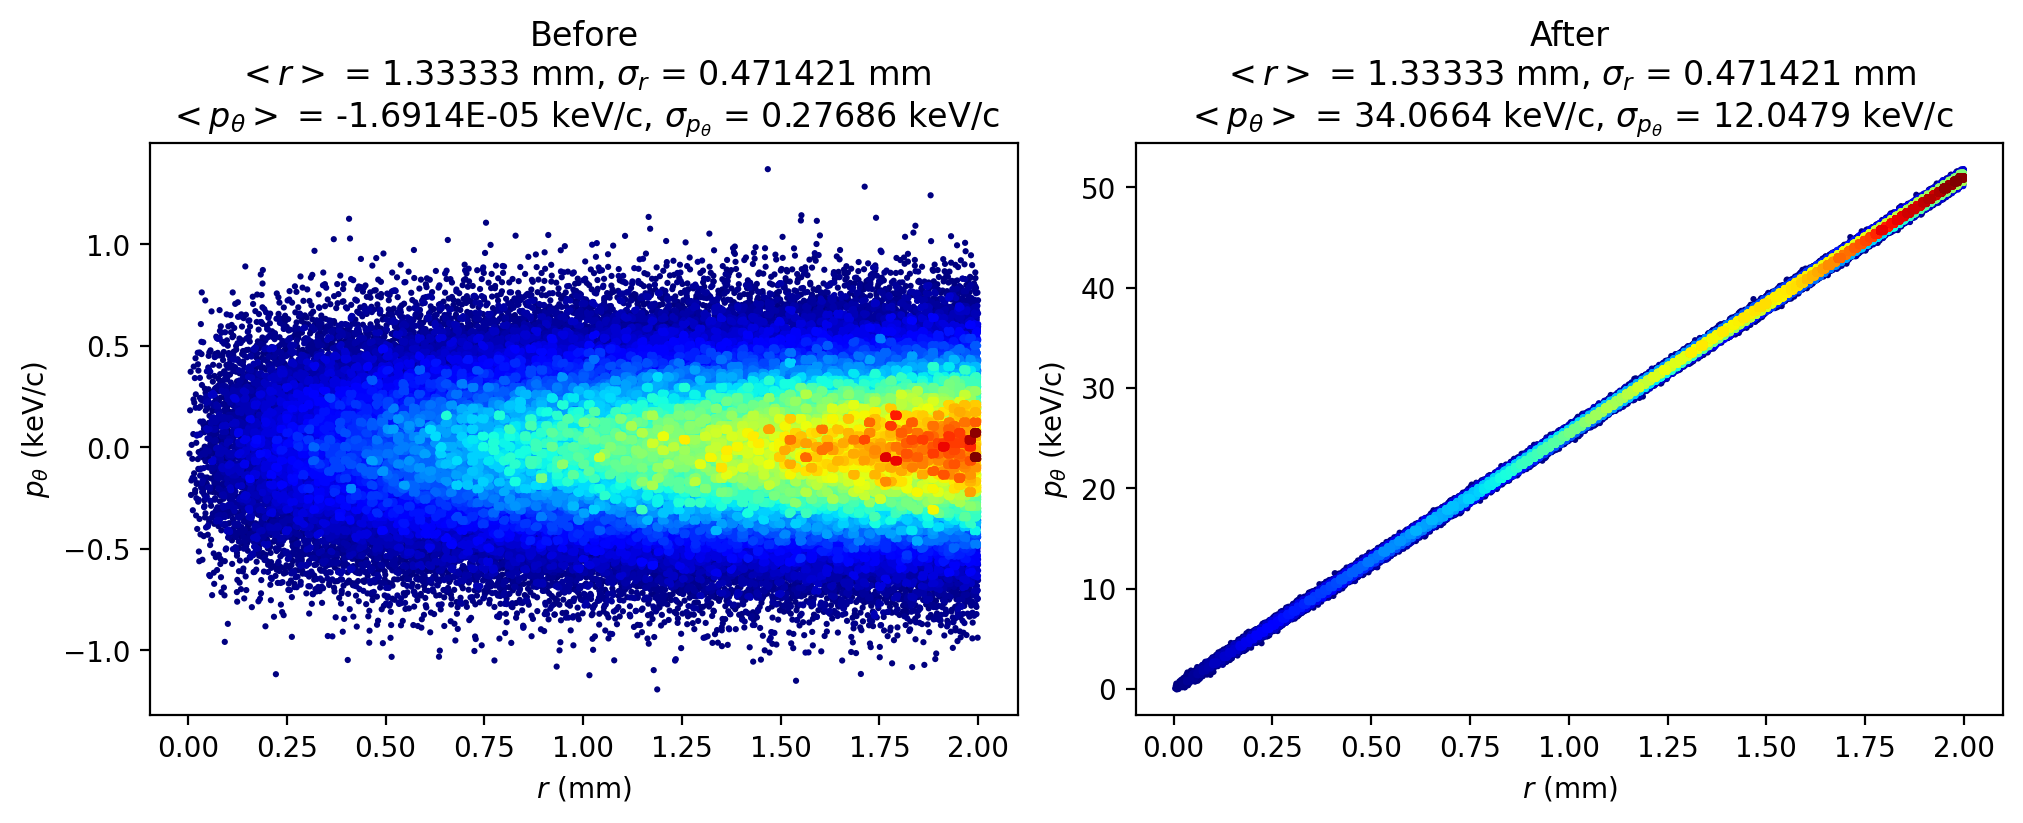

In [11]:
from distgen.physical_constants import MC2
from distgen.transforms import magnetize

gen = Generator('data/beer.can.in.yaml',verbose=0)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ibeam = gen.beam()
plot_dist2d(ibeam, 'r', units['r'], 'ptheta', units['px'], ax=ax[0], title_on=True);
ax[0].set_title(f'Before\n{ax[0].get_title()}')

Lmag = -50*unit('micrometer')*MC2.magnitude*unit('eV/c')
print(f'{Lmag.units:~P}')
magnetize = {
    'type':'magnetize r:ptheta',
    'magnetization':{'value': Lmag.magnitude, 'units': str(Lmag.units)},
}

gen['transforms']={'m':magnetize}

print('YAML:\n',yaml.dump(gen.input['transforms']))

fbeam = gen.beam()
plot_dist2d(fbeam, 'r', units['r'], 'ptheta', units['px'], ax=ax[1], title_on=True);
ax[1].set_title(f'After\n{ax[1].get_title()}');

eni = 0.5*(ibeam.emitt('x','normalized') + ibeam.emitt('y', 'normalized'))
enf = 0.5*(fbeam.emitt('x','normalized') + fbeam.emitt('y', 'normalized'))

enf0 = np.sqrt(eni**2 + (Lmag/(1*unit('GB')))**2)
err = (enf/enf0-1)

print(f'Initial emittance: {eni.to("um"):G~P}')
print(f'Final emittance: {enf.to("um"):G~P}')
print(f'Error: {100*err.magnitude} %')

# Polynomial

It is possible to apply a polynomial map in one beam variable to a second using the polynomial function:

$p \rightarrow p + \sum_{n=0}^N a_n (x-\mathcal{O})^n$.  

Here $p_i$ is the dependent variable before the transformation (this term can be left out by specifying the keyword zero_dependent_var=True),  the $a_n$ specify the polynomial coefficients, and $\mathcal{O}$ is the expansion origin.  In the example used below, a quartic polynomial in $z$ is applied to $p_z$ mimicing the effect of an RF cavity:

YAML input:
 pt:
  coefficients:
  - units: megaelectron_volt / speed_of_light
    value: 1000.0
  - units: electron_volt / meter / speed_of_light
    value: 0.0
  - units: gigahertz ** 2 * megaelectron_volt * radian ** 2 * second ** 2 / meter
      ** 2 / speed_of_light
    value: -3.7117185708535e-13
  type: polynomial z:pz



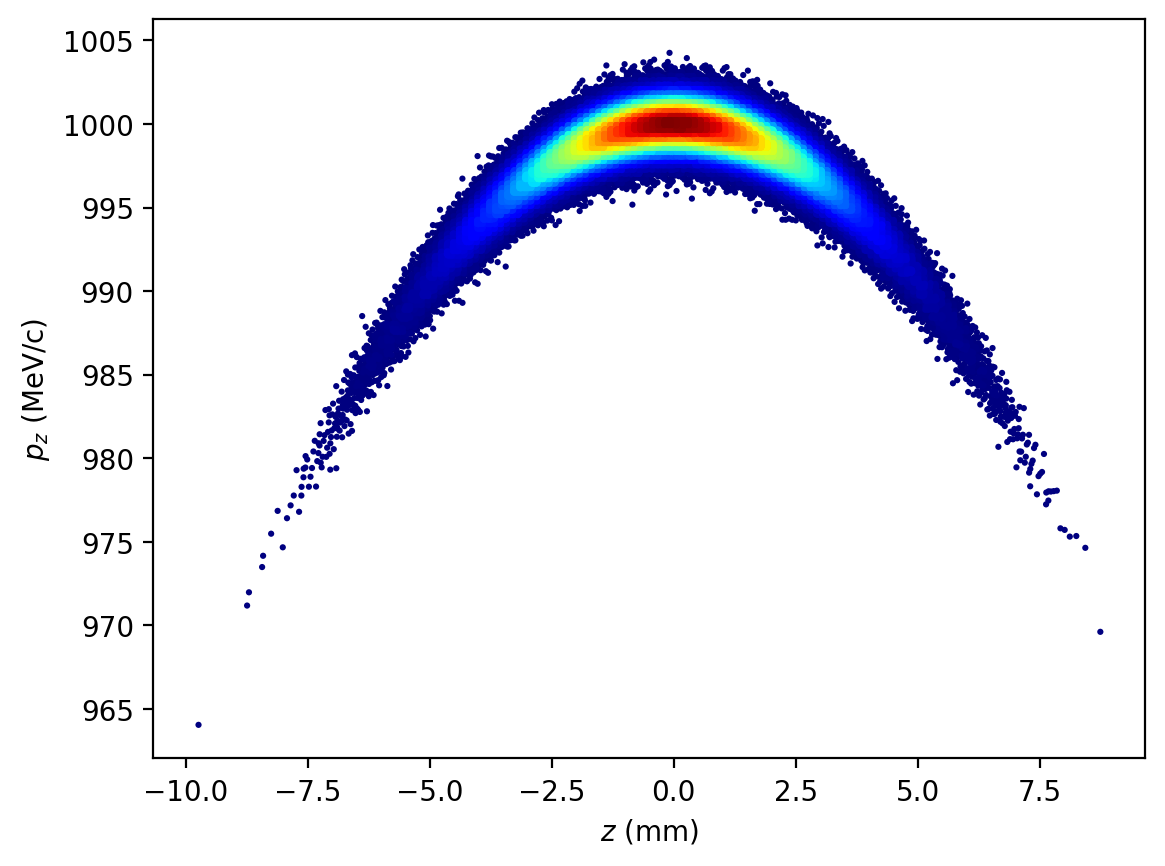

In [12]:
from distgen.physical_constants import pi,c
from distgen.transforms import polynomial
import numpy as np

gen=Generator('data/gaussian.in.yaml',verbose=0)

V0 = 1000*unit('MeV/c')
w = 2*pi*1.3*unit('GHz')
k = w/c
phi = -2.5*unit('deg')
c3 = -0.5*V0*k**2

polytrans = {
    'type':'polynomial z:pz',
    'coefficients':[
        {'value': V0.magnitude, 'units': str(V0.units)},
        {'value': 0.0, 'units': 'eV/c/meter'},
        {'value': c3.magnitude, 'units': str(c3.units)},
    ]
}

gen['transforms']={'pt':polytrans}

beam = gen.beam()
print('YAML input:\n',yaml.dump(gen.input['transforms']))

plot_dist2d(beam, 'z', units['z'], 'pz', units['pz']);

# Cosine

It is often convenient to impart a cosine like energy spread to beam's longitudinal momentum.  This can be accomplished using the cosine transform:

$p \rightarrow p + A\cos(\omega v + \phi)$.

YAML input:
 tc:
  amplitude:
    units: megaelectron_volt / speed_of_light
    value: 1000.0
  omega:
    units: gigahertz * radian * second / meter
    value: 2.724598528537186e-08
  phase:
    units: degree
    value: -2.5
  type: cosine z:pz



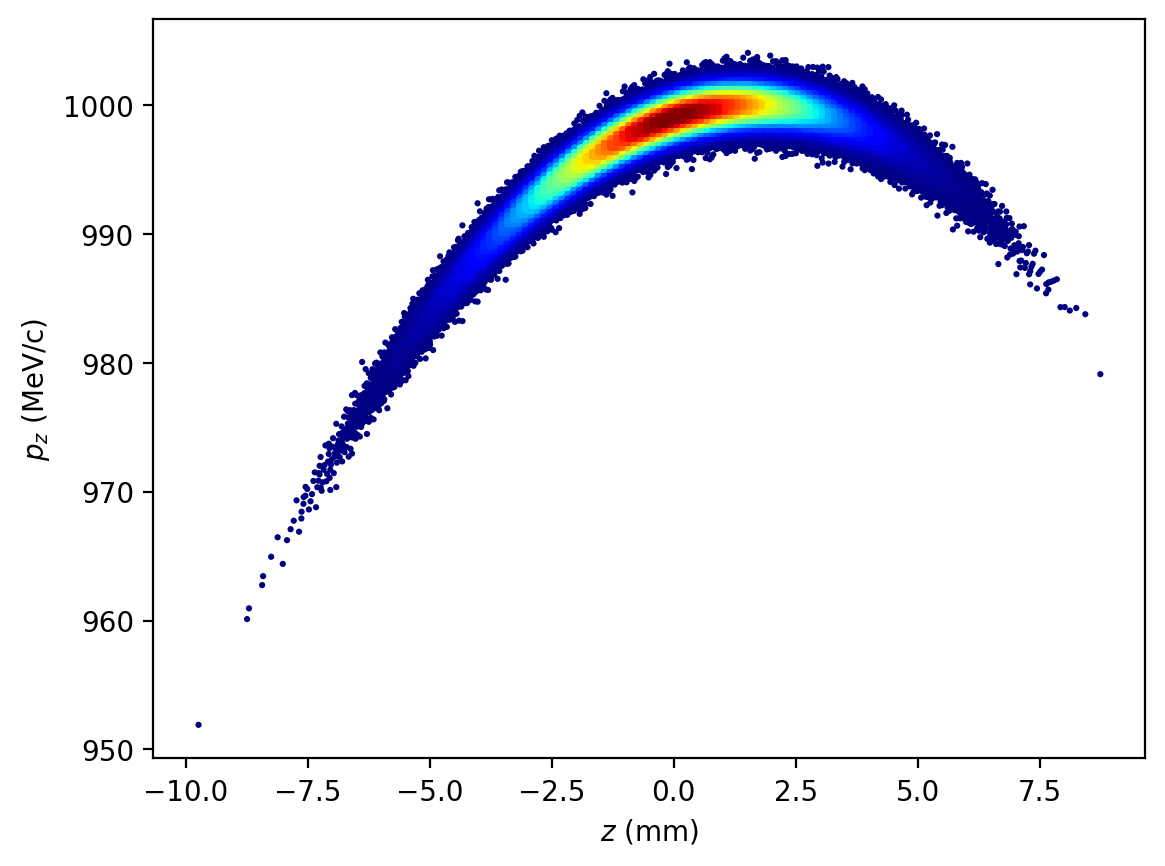

In [13]:
from distgen.physical_constants import pi,c
from distgen.transforms import cosine
import numpy as np

gen=Generator('data/gaussian.in.yaml',verbose=0)

w = 2*pi*1.3*unit('GHz')
k = w/c

tcos = {
    'type':'cosine z:pz',
    'amplitude':{'value':1000, 'units':'MeV/c'},
    'phase':{'value':-2.5, 'units':'deg'},
    'omega':{'value': k.magnitude, 'units': str(k.units)}
}

gen['transforms']={'tc':tcos}

beam = gen.beam()
print('YAML input:\n',yaml.dump(gen.input['transforms']))

plot_dist2d(beam, 'z', units['z'], 'pz', units['pz']);

# Setting Twiss parameters 

Often for beams at energy the user may wish to set beam Twiss parameters $\beta$, $\alpha$, and $\epsilon$ for a desired 2D phase space.

YAML input:
 boost:
  delta:
    units: gigaelectron_volt / speed_of_light
    value: 1.0
  type: translate pz
order:
- boost
- twiss
twiss:
  alpha:
    units: dimensionless
    value: -1.0
  beta:
    units: meter
    value: 12.5
  emittance:
    units: nanometer
    value: 2.0
  type: set_twiss x

Initial Horizontal Twiss params:
beta: 999999 mm, alpha: 0.000112133, eps: 1.000 nm

Final Horizontal Twiss params:
beta: 12.5 m, alpha: -1, eps: 2.000 nm


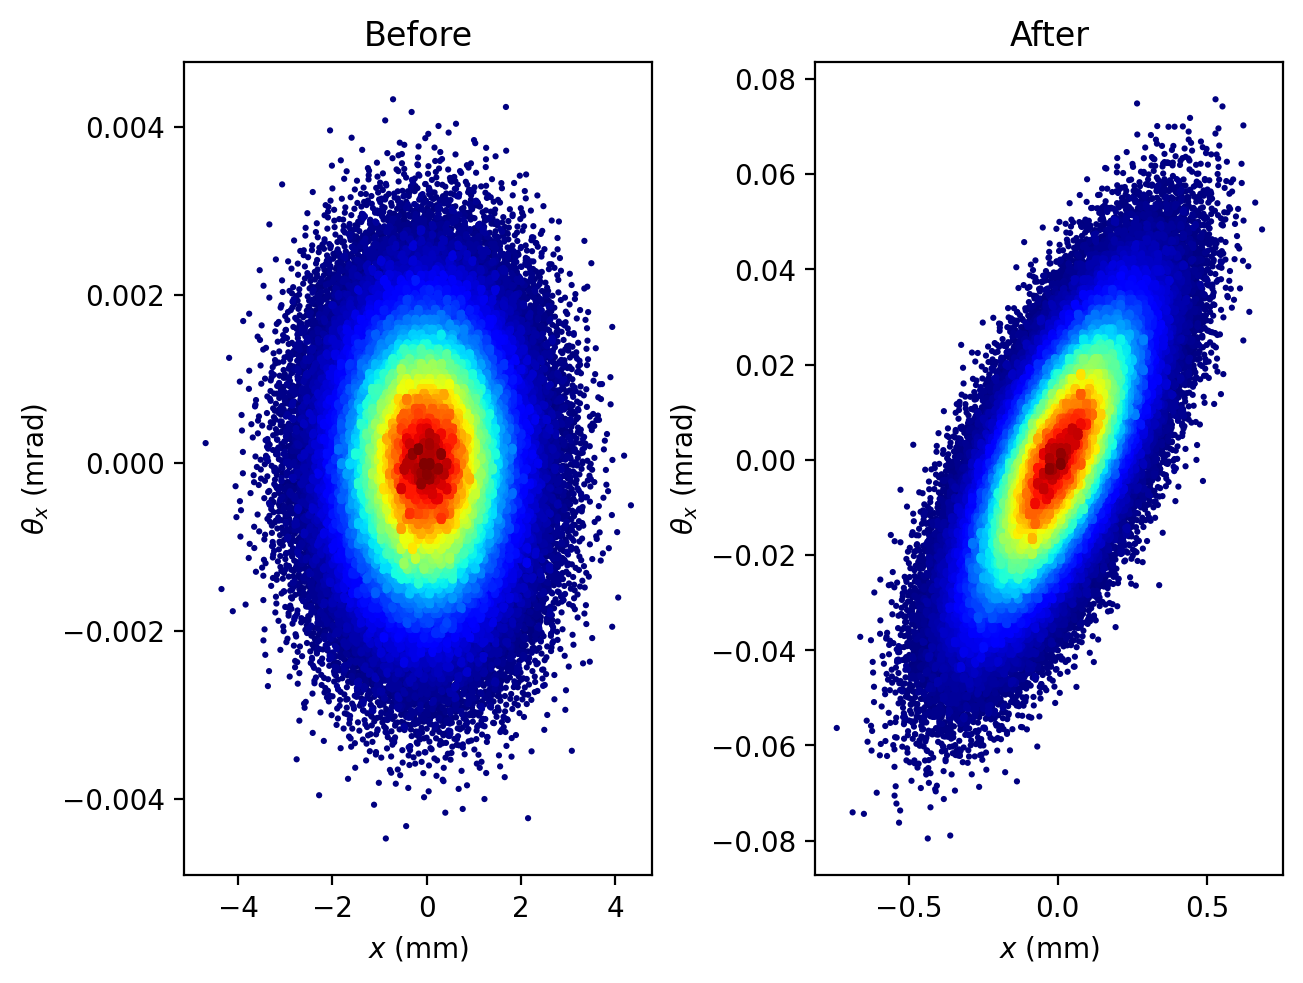

In [14]:
from distgen.transforms import set_twiss, translate
filename = "data/gaussian.in.yaml"

gen = Generator(filename, verbose=0) 

boost_pz = {'type':'translate pz',  'delta': { 'value':1, 'units':'GeV/c',}}

gen['transforms']={'boost':boost_pz}
beam1 = gen.beam()

twiss_x = {
    'type':'set_twiss x', 
    'beta': {'value':12.5, 'units':'m',},
    'alpha':{'value':-1, 'units':''},
    'emittance': {'value':2, 'units':'nm'}
}

gen['transforms']={'boost':boost_pz, 'twiss':twiss_x, 'order':['boost','twiss']}
beam2 = gen.beam()

print('YAML input:\n',yaml.dump(gen.input['transforms']))

print('Initial Horizontal Twiss params:')
print(f'beta: {beam1.Beta("x"):G~P}, alpha: {beam1.Alpha("x"):G~P}, eps: {beam1.emitt("x","geometric").to("nm"):0.3f~P}')

fig, ax = plt.subplots(1, 2, constrained_layout=True)
plot_dist2d(beam1, 'x', units['x'], 'thetax', units['thetax'], ax=ax[0]);
ax[0].set_title('Before')

plot_dist2d(beam2, 'x', units['x'], 'thetax', units["thetax"], ax=ax[1]);
ax[1].set_title('After');

print('\nFinal Horizontal Twiss params:')
print(f'beta: {beam2.Beta("x").to("m"):G~P}, alpha: {beam2.Alpha("x"):G~P}, eps: {beam2.emitt("x","geometric").to("nm"):0.3f~P}')